<h3>Portfollio poject</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split


pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.style.use('seaborn-whitegrid')

In [2]:
# loading the train dataset
df = pd.read_csv("./files/RealEstate_Georgia.csv")

<p>First we should create some functions which we may need in the future</p>

In [3]:
def square():
    return feature ** 2

def cube(feature):
    return feature ** 3

def sqrt(feature):
    return np.sqrt(feature)

def log(feature, add= 0):
    return np.log(feature + add)

<h3>OVERVIEW & LITTLE CLEANING<h3>

In [4]:
#printing the first 3 rows
df.head(3)

,id,stateId,countyId,cityId,country,datePostedString,is_bankOwned,is_forAuction,event,time,...,parking,garageSpaces,hasGarage,levels,pool,spa,isNewConstruction,hasPetsAllowed,homeType,county
0,31503-110785431,16,17,55064,USA,7/12/2021,0,0,Listed for sale,1630000000000.000,...,0,0,0,0,0,0,0,0,SINGLE_FAMILY,Brantley County
1,31503-76611082,16,18,55064,USA,7/12/2021,0,0,Listed for sale,1630000000000.000,...,0,0,0,0,0,0,0,0,SINGLE_FAMILY,Ware County
2,31503-93126153,16,19,55064,USA,7/10/2021,0,0,Listed for sale,1630000000000.000,...,1,0,0,0,0,0,0,0,SINGLE_FAMILY,Ware County


In [5]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} cols')

The dataset has 13804 rows and 38 cols


<p>Before doing anything else lets see if our rows has any duplicates</p

In [6]:
duplicates = df.shape[0] - df['id'].drop_duplicates().shape[0]
print(f"Our dataset has {duplicates} records")

Our dataset has 1258 records


In [7]:
cols = ['id', 'cityId', 'price', 'latitude', 'longitude']

duplicated_rows = df[df['id'].duplicated(keep=False)][cols]
duplicated_rows.sort_values(by='id').head(6)

,id,cityId,price,latitude,longitude
13542,30004-14685821,16733,1799000,34.079,-84.331
4879,30004-14685821,16733,1799000,34.079,-84.331
13548,30004-2078310784,54219,0,34.077,-84.350
4895,30004-2078310784,54219,0,34.077,-84.350
4093,30005-2069916603,397383,479000,34.066,-84.196
12315,30005-2069916603,397383,479000,34.066,-84.196


<p>It's now clear that there are a great amount of duplicated rows. We need to remove them. We can do this in the following way</p>

In [8]:
df = df.drop_duplicates(subset='id') # keeping the first occuring value only

<h3>TARGET VARIABLES ANALYSIS</h3>

<p>Next lets obeserve the characteristic of the target variable first</p>

In [9]:
y = df['price']

y.describe()

count      12546.000
mean      369839.634
std       665156.224
min            0.000
25%        94500.000
50%       249000.000
75%       425000.000
max     30504000.000
Name: price, dtype: float64

<p>We have a problem. It seems there are some houses which have 0 price as value. Lets see which ones are they</p>

In [10]:
rows_with_zero_price = df[y == 0]

print(f"The number of rows with zero price are {rows_with_zero_price.shape[0]}")

The number of rows with zero price are 43


<p>After spending some time analyzing the sale price with excel I found out that there are a lot of houses with very low sale price which is very weird</p>

In [11]:
print(f"The number of rows with zero price are {df[y <= 1000].shape[0]}")

The number of rows with zero price are 49


<p>After a little bit of searching online I found out that there almost no houses with less then 1000 dollars in Georgia. Even if there are they are very rare or outlayers. Since we have a lot of records it would not matter much remove them from our dataset</p>

In [12]:
index_to_drop = df[y <= 1000].index

df = df.drop(index_to_drop)

<p>There is a good article on how handle zero inflated target values <a href='https://towardsdatascience.com/zero-inflated-regression-c7dfc656d8af'> Zero-Inflated Regression</a>  by <b>Dr. Robert Kübler</b></p>

<p>Now before doing anything else we will split the data in training, validation and test dataset. So no matter what we do to the training and validation dataset it won't efftect the test</p>



<p>Lets resample the entire datset first to randomize the dataset to avoid any bias in location</p>


In [13]:

# df = df.reindex(np.random.permutation(df.index))

df = df.sample(frac=1.0, random_state=0)

In [14]:
x = df.drop('price', axis=1)
y = df['price']
seed = 0

# getting training data
X_train, X_rem, y_train, y_rem = train_test_split(x, y, test_size=0.3, random_state=seed)

X_test, X_val, y_test, y_val = train_test_split(X_rem, y_rem, test_size=0.6, random_state=seed)

In [15]:
print(f'The shape of x_train: {X_train.shape}, x_val: {X_val.shape}, x_test: {X_test.shape}')

The shape of x_train: (8747, 37), x_val: (2250, 37), x_test: (1500, 37)


In [16]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)

In [17]:
train_df.head(2)

,id,stateId,countyId,cityId,country,datePostedString,is_bankOwned,is_forAuction,event,time,...,garageSpaces,hasGarage,levels,pool,spa,isNewConstruction,hasPetsAllowed,homeType,county,price
5294,30224-69903142,16,183556,11738,USA,6/28/2021,0,0,Listed for sale,1620000000000.000,...,0,0,One,0,0,0,0,SINGLE_FAMILY,Spalding County,229900
6760,30188-2078680774,16,233144,48573,USA,7/9/2021,0,0,Listed for sale,1590000000000.000,...,0,0,0,0,0,1,0,TOWNHOUSE,Cherokee County,400000


<p>Now that we are done with initial preparation we will clean, analyze and build model</p>

<p>Now that we have removed outlayers lets see the distribution of prices in train_df</p>

In [18]:
train_df['price'].describe()

count       8747.000
mean      380238.660
std       664262.171
min         1250.000
25%        98265.000
50%       250000.000
75%       429000.000
max     19740000.000
Name: price, dtype: float64

<p>See in the future how the distribution can be perfectly balanced</p>

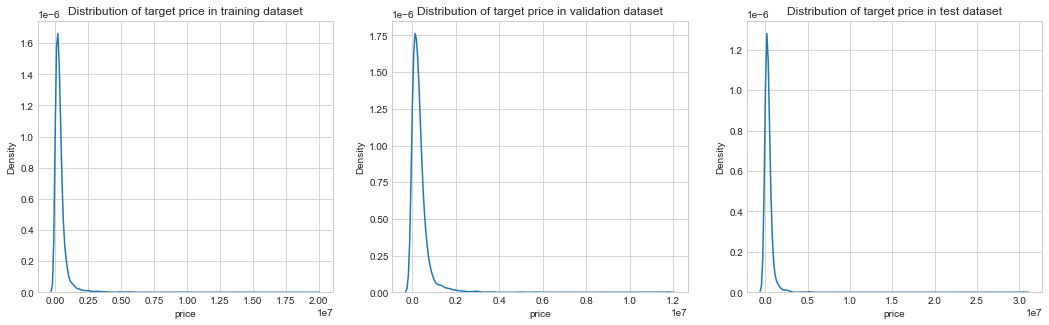

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

sns.kdeplot(train_df['price'], ax=ax1)
sns.kdeplot(val_df['price'], ax=ax2)
sns.kdeplot(test_df['price'], ax=ax3)

ax1.set_title("Distribution of target price in training dataset")
ax2.set_title("Distribution of target price in validation dataset")
ax3.set_title("Distribution of target price in test dataset")

plt.show()

In [20]:
print(f'The price has a skewness of {train_df["price"].skew()}')
print(f'The price has a kurtosis of {train_df["price"].kurtosis()}')

The price has a skewness of 10.644532849909613
The price has a kurtosis of 194.83879336087975


<p>Since linear regression works much better with normally distributed data we need reduce skewness and kurtosis</p>

<p>To handle skewness what we can do is try different transformation like log, Square Root, boxcox transformation. For further clarification you can see this article <a href='https://towardsdatascience.com/top-3-methods-for-handling-skewed-data-1334e0debf45'>Top 3 Methods for Handling Skewed Data by Dario Radečić</a></p>

In [21]:
from scipy.stats import boxcox

In [22]:
box_price = pd.Series(boxcox(train_df['price'])[0], name='price')
log_price = np.log(train_df['price'])
sqrt_price = np.sqrt(train_df['price'])

In [23]:
print(f'The boxcox price has a skewness of {box_price.skew()}')
print(f'The boxcox price has a kurtosis of {box_price.kurtosis()}\n')

print(f'The log price has a skewness of {log_price.skew()}')
print(f'The log price has a kurtosis of {log_price.kurtosis()}\n')

print(f'The sqrt price has a skewness of {sqrt_price.skew()}')
print(f'The sqrt price has a kurtosis of {sqrt_price.kurtosis()}')

The boxcox price has a skewness of 0.01927513776162235
The boxcox price has a kurtosis of 0.5701669145719981

The log price has a skewness of -0.520576400886599
The log price has a kurtosis of 0.4139770321465992

The sqrt price has a skewness of 2.3828390334279694
The sqrt price has a kurtosis of 13.773281544462536


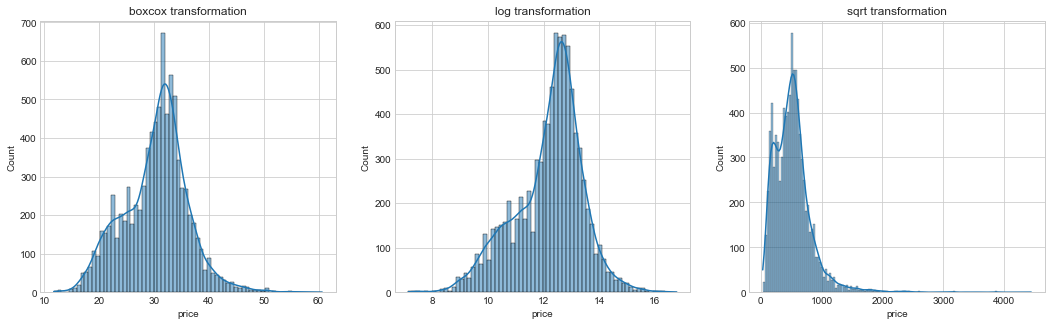

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1 = sns.histplot(box_price, kde=True, ax=ax1)

ax2 = sns.histplot(log_price, kde=True, ax=ax2)

ax3 = sns.histplot(sqrt_price, kde=True, ax=ax3)

ax1.set_title('boxcox transformation')
ax2.set_title('log transformation')
ax3.set_title('sqrt transformation')

plt.show()

<p>Both boxcox and log transformation are a good choice. But here we will do log transformation for simplicity. But we may change it in the future</p>

In [25]:
train_df['price'] = log(train_df['price'])
val_df['price'] = log(val_df['price'])
test_df['price'] = log(test_df['price'])

<p>Now that we have sorted out the target variables lets move on to the features. But we will only focus on train dataset features and only after coming to a conclustion will we move the test and validation dataset</p>

<H3>HANDLING NULL VALUES AND CLEANING</H3>

In [26]:
train_df.dtypes

id                     object
stateId                 int64
countyId                int64
cityId                  int64
country                object
datePostedString       object
is_bankOwned            int64
is_forAuction           int64
event                  object
time                  float64
pricePerSquareFoot      int64
city                   object
state                  object
yearBuilt               int64
streetAddress          object
zipcode                 int64
longitude             float64
latitude              float64
hasBadGeocode           int64
description            object
currency               object
livingArea              int64
livingAreaValue         int64
lotAreaUnits           object
bathrooms               int64
bedrooms                int64
buildingArea            int64
parking                 int64
garageSpaces            int64
hasGarage               int64
levels                 object
pool                    int64
spa                     int64
isNewConst

<p>The first thing that comes to my mind after seeing this is that we should convert datepostedstring as int data type, at the it feels weird that levels is an object data type when it represents the number of floors</p>

In [27]:
# converting datetime(string) to datetime(datetime)
train_df['dateposted']  = pd.to_datetime(train_df['datePostedString'])
train_df.drop('datePostedString', axis=1, inplace=True)

In [28]:
train_df['levels'].unique()

array(['One', '0', 'Two', 'Three Or More', 'One and One Half',
       'Multi/Split', 'Two-Two Story Foyer', '3 Story',
       'Two-Three Or More', '2 Story or More',
       'One-Manufactured Home 1 Story', 'Tri Level', 'Split Level',
       'Two-Split Foyer', 'Two-Split Level', 'Two-Multi/Split',
       'Over 2 Stories', 'Split Foyer', 'Other-See Remarks',
       'Two and One-Half', 'One-Two', 'Split Foyer-Split Level',
       'One-One and One Half', 'One-Mobile Home 1 Story',
       'Two-Foyer - 2 Story', 'Multi/Split-Split Level',
       'Manufactured Home 1 Story', 'Three Or More-Two Story Foyer',
       'One and One Half-Two', 'Tri Level-Split Level', 'Split Level-Two',
       'One-One and One Half-Two', 'Tri-Level', 'One-Two Story Foyer'],
      dtype=object)

<p>It seems levels or floors are represented as categorical variables which we need to feature engineer later but lets just keep it as it is and just replace 0 with 'Zero'</p>

In [29]:
# replaced level value from 0 to Zero
train_df['levels'].replace({'0': 'Zero'}, inplace=True)

<p>Next we will removes features we will not need as they do not have any relation with price</p>

In [30]:
# dropped ['state', 'id', 'country', 'stateId', 'currency'] features
train_df.drop(['state', 'id', 'country', 'stateId', 'currency'], axis=1, inplace=True) 

<p>

<p>If you explore the dataset well you will see that you will see that livingArea and livingAreaValue has the same values for all rows</p>

In [31]:
# panda equal method which tells if two columns are equal or not
train_df['livingArea'].equals(train_df['livingAreaValue'])

True

<p>We will drop the livingArea feature</p>

In [32]:
# dropped livingAreaValue columns
train_df.drop(columns=['livingAreaValue'], inplace=True)

In [33]:
train_df.columns

Index(['countyId', 'cityId', 'is_bankOwned', 'is_forAuction', 'event', 'time',
       'pricePerSquareFoot', 'city', 'yearBuilt', 'streetAddress', 'zipcode',
       'longitude', 'latitude', 'hasBadGeocode', 'description', 'livingArea',
       'lotAreaUnits', 'bathrooms', 'bedrooms', 'buildingArea', 'parking',
       'garageSpaces', 'hasGarage', 'levels', 'pool', 'spa',
       'isNewConstruction', 'hasPetsAllowed', 'homeType', 'county', 'price',
       'dateposted'],
      dtype='object')

<p>Infact there also a lot of similarites between some other features but for now we will just ignore them and letter find out which features has most meaning</p>

<p>check if there are any null values</p>

In [34]:
train_df.isnull().sum().sort_values(ascending=False).head()

description    66
dateposted      1
bathrooms       0
price           0
county          0
dtype: int64

<p>Since there is only one date value missing we will just remove that row and for description we will remove it as it is not that important for our dataset as the what the description feature want to describe is already present in the other datasets
</p>

In [35]:
train_df.dropna(subset=['dateposted'], inplace=True)

<p>A overview of training dataset</p>

In [36]:
# dropped description
train_df.drop(columns=['description'], inplace=True)

In [37]:
train_df.describe()

,countyId,cityId,is_bankOwned,is_forAuction,time,pricePerSquareFoot,yearBuilt,zipcode,longitude,latitude,...,bedrooms,buildingArea,parking,garageSpaces,hasGarage,pool,spa,isNewConstruction,hasPetsAllowed,price
count,8746.000,8746.000,8746.000,8746.000,8746.000,8746.000,8746.000,8746.000,8746.000,8746.000,...,8746.000,8746.000,8746.000,8746.000,8746.000,8746.000,8746.000,8746.000,8746.000,8746.000
mean,151614.820,32279.318,0.000,0.000,1622044934827.350,124.557,1319.060,30667.560,-83.777,33.349,...,2.313,1177.364,0.453,0.498,0.357,0.052,0.060,0.044,0.004,12.193
std,98007.753,38633.115,0.000,0.019,33083862359.345,2194.533,941.022,555.510,1.047,1.063,...,2.157,1908.196,0.498,0.944,0.479,0.222,0.238,0.206,0.059,1.228
min,17.000,0.000,0.000,0.000,252000000000.000,0.000,0.000,30002.000,-85.574,30.626,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7.131
25%,69334.250,13709.000,0.000,0.000,1620000000000.000,0.000,0.000,30189.000,-84.469,32.625,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,11.494
50%,136661.000,28803.000,0.000,0.000,1630000000000.000,94.000,1965.000,30530.500,-84.054,33.698,...,3.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,12.429
75%,240738.500,43545.000,0.000,0.000,1630000000000.000,161.000,1999.000,31052.000,-83.344,34.053,...,4.000,1998.750,1.000,0.000,1.000,0.000,0.000,0.000,0.000,12.969
max,333689.000,397383.000,0.000,1.000,1630000000000.000,205000.000,9999.000,31909.000,-80.842,34.993,...,89.000,87120.000,1.000,8.000,1.000,1.000,1.000,1.000,1.000,16.798


In [38]:
min_values = train_df.describe().loc['min']
min_values[min_values == 0]

cityId               0.000
is_bankOwned         0.000
is_forAuction        0.000
pricePerSquareFoot   0.000
yearBuilt            0.000
hasBadGeocode        0.000
livingArea           0.000
bathrooms            0.000
bedrooms             0.000
buildingArea         0.000
parking              0.000
garageSpaces         0.000
hasGarage            0.000
pool                 0.000
spa                  0.000
isNewConstruction    0.000
hasPetsAllowed       0.000
Name: min, dtype: float64

<P>Most of them looks okay but cityid, pricePerSquareFoot, yearBuilt, livingArea, LivingAreaValue, bedrooms, livingAreaValue, bathrooms, buildingArea looks pretty weird as they are continous or values which should not be zero</P>

<P>After explocring the data a bit we can see that in year Built and pricePerSquareFoot 0 simply means null value. But for other continuos features 0 means they simply did not have those features like a Lot would not have bedrooms, or bathrooms or building Area</P>

<p>We will decide what to do with the null values later</p>

In [39]:
cities = train_df[['cityId', 'city']]
cities.head()

,cityId,city
5294,11738,Griffin
6760,48573,Woodstock
9108,54219,Roswell
6005,11799,Hapeville
1788,0,Cohutta


In [40]:
cities.isnull().sum()

cityId    0
city      0
dtype: int64

<p>But previously we found out that cityId has 0 values which is very weird</p>

In [41]:
cities[cities['cityId'] == 0].head()

,cityId,city
1788,0,Cohutta
13107,0,Midville
10650,0,Jonesboro
10183,0,Bishop
1342,0,Uvalda


<p>We can say that it was probably a mistake during the data collection and they forgot to add cityid. Since we can just use the city as feature we will discard cityId</p>

In [42]:
# dropped cityid
train_df.drop(columns=['cityId'], inplace=True)

<h3>Exploratory Data Analysis</h3>

In [43]:
train_df.head(2)

,countyId,is_bankOwned,is_forAuction,event,time,pricePerSquareFoot,city,yearBuilt,streetAddress,zipcode,...,hasGarage,levels,pool,spa,isNewConstruction,hasPetsAllowed,homeType,county,price,dateposted
5294,183556,0,0,Listed for sale,1620000000000.000,161,Griffin,1956,709 Forrest Ave,30224,...,0,One,0,0,0,0,SINGLE_FAMILY,Spalding County,12.345,2021-06-28
6760,233144,0,0,Listed for sale,1590000000000.000,160,Woodstock,2021,The Magnolia Plan,30188,...,0,Zero,0,0,1,0,TOWNHOUSE,Cherokee County,12.899,2021-07-09


In [44]:
X = train_df.copy().drop(columns=['price'])
y = train_df['price']

X['dateposted'] =  X['dateposted'].astype('object')

for col in X.select_dtypes(include='object'):
    X[col] = X[col].factorize()[0]

discrete_features = X.dtypes == 'int64'

In [45]:
mut_info = pd.Series(mutual_info_regression(X, y, discrete_features=discrete_features), index=X.columns)

In [46]:
mut_info.sort_values(ascending=False)

bathrooms            0.459
zipcode              0.446
pricePerSquareFoot   0.426
livingArea           0.385
city                 0.345
bedrooms             0.314
buildingArea         0.292
yearBuilt            0.290
county               0.268
streetAddress        0.262
levels               0.253
latitude             0.234
homeType             0.229
longitude            0.202
hasGarage            0.190
parking              0.174
garageSpaces         0.167
dateposted           0.165
event                0.082
spa                  0.041
time                 0.038
pool                 0.024
isNewConstruction    0.023
lotAreaUnits         0.019
is_forAuction        0.000
hasPetsAllowed       0.000
is_bankOwned         0.000
hasBadGeocode        0.000
countyId             0.000
dtype: float64

<p>Most the features has some degree of realationship with price value but some are also very unexpected like bathrooms having so high relation(one reason for it can be that more bathrooms means bigger house and more facilities) or how is_forAuction, is_bankOwned has such poor realtionship. Lets explore them a bit</p>

<p>First lets divide the datas into categorical and quantitative datasets</p>

In [61]:
cat_df = train_df.select_dtypes(include=['object'])
con_df = train_df.drop(columns=cat_df.columns).drop(columns=['dateposted']) # removing dateposted but will analyze it later

cat_df = cat_df.join(train_df['price'])

In [52]:
cat_melt = cat_df.melt(value_vars=cat_df.columns, id_vars=['price'])
con_melt = con_df.melt(value_vars=con_df.columns, id_vars=['price'])

In [76]:
cat_df['streetAddress'].nunique()

8714

In [ ]:
cat_df

In [79]:

(cat_df['city'].value_counts() <= 10).sum()

254

In [66]:
cat_df.unique()

AttributeError: 'DataFrame' object has no attribute 'unique'

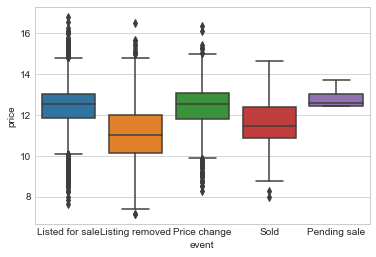

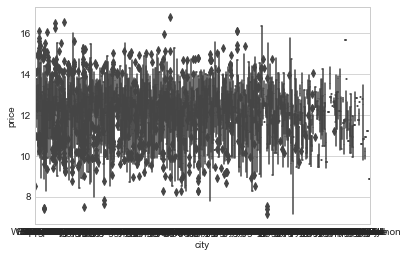

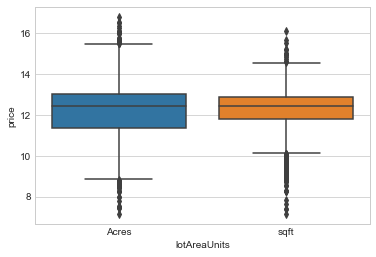

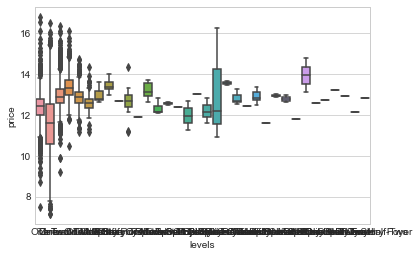

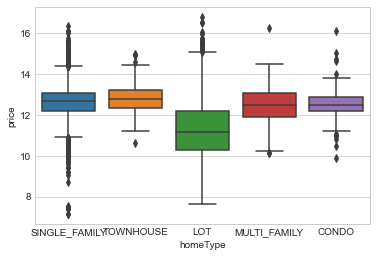

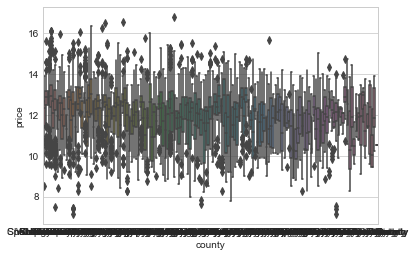

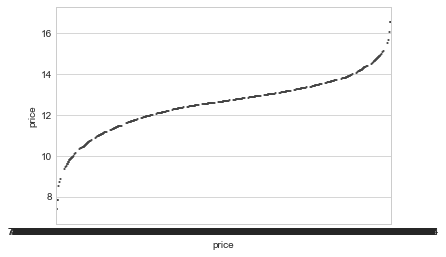

In [77]:
for col in cat_df.drop(columns=['streetAddress']).columns:
    sns.boxplot(x=cat_df[col], y=cat_df['price'])
    
    plt.show()

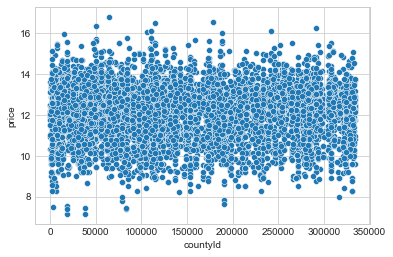

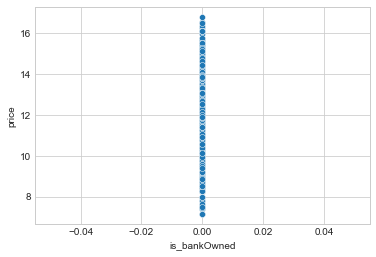

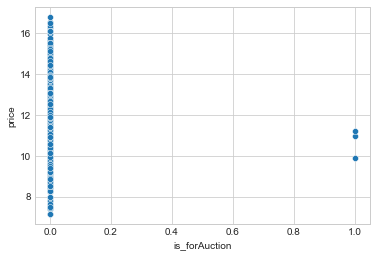

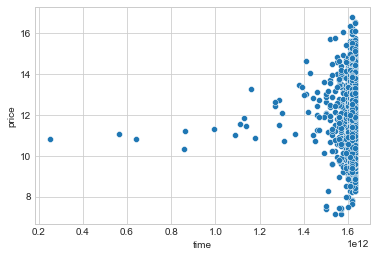

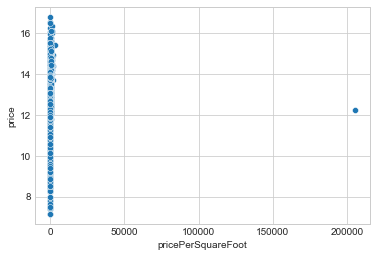

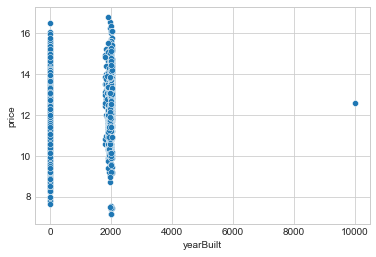

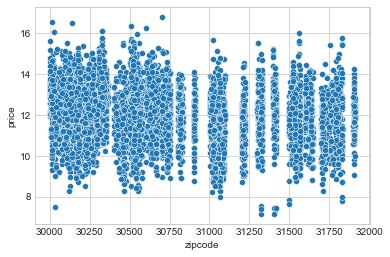

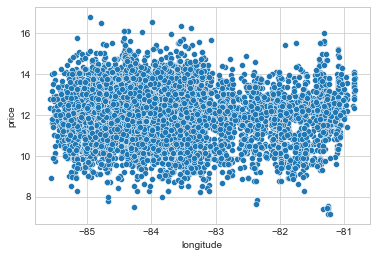

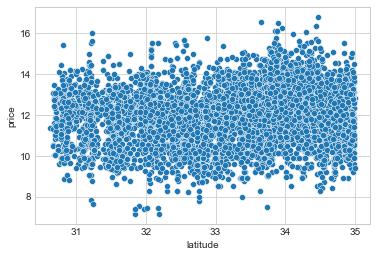

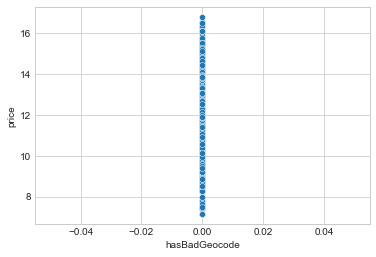

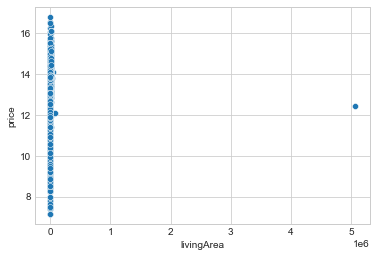

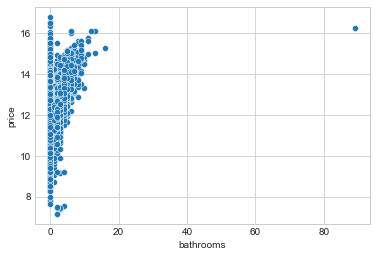

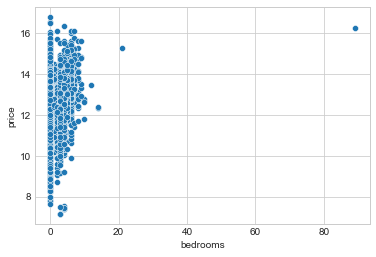

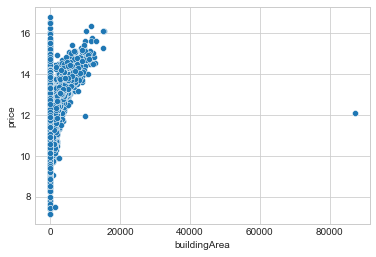

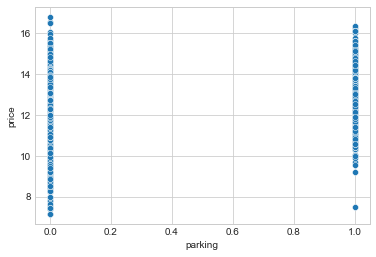

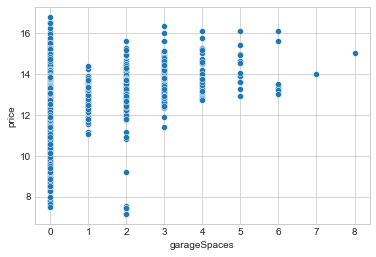

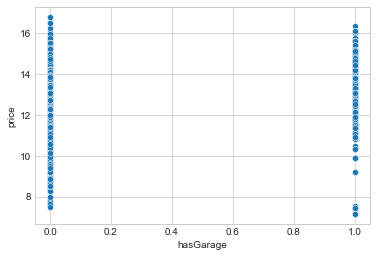

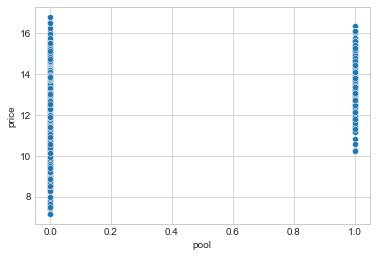

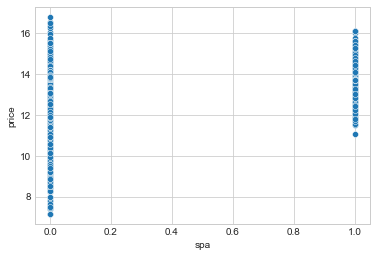

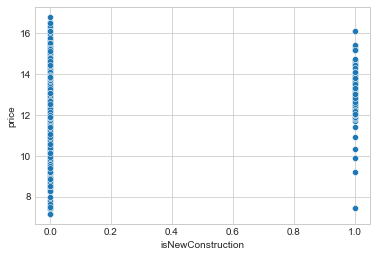

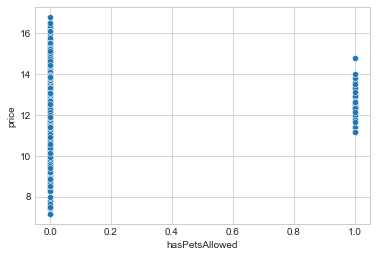

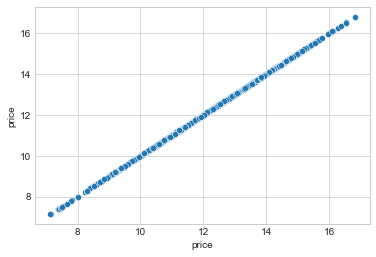

In [63]:
for col in con_df.columns:
    sns.scatterplot(x=con_df[col], y=con_df['price'])
    
    plt.show()

<H3>FEATURE ENGINEERING & CLEANING</H3>

<p>For keeping track lets go through the features one by one</p>

In [46]:
train_df.columns

Index(['countyId', 'is_bankOwned', 'is_forAuction', 'event', 'time',
       'pricePerSquareFoot', 'city', 'yearBuilt', 'streetAddress', 'zipcode',
       'longitude', 'latitude', 'hasBadGeocode', 'livingArea', 'lotAreaUnits',
       'bathrooms', 'bedrooms', 'buildingArea', 'parking', 'garageSpaces',
       'hasGarage', 'levels', 'pool', 'spa', 'isNewConstruction',
       'hasPetsAllowed', 'homeType', 'county', 'price', 'dateposted'],
      dtype='object')

<P>We need to look more into levels<p>

In [108]:
train_df.groupby('levels')['countyId'].count().sort_values()

levels
One-Two Story Foyer                 1
Tri-Level                           1
Manufactured Home 1 Story           1
Two-Three Or More                   1
Tri Level-Split Level               1
Two-Split Level                     1
One and One Half-Two                1
One-Mobile Home 1 Story             1
Split Level-Two                     1
One-One and One Half-Two            1
Split Foyer-Split Level             1
Over 2 Stories                      1
Three Or More-Two Story Foyer       2
Two-Multi/Split                     2
Two and One-Half                    2
Two-Foyer - 2 Story                 2
One-Manufactured Home 1 Story       2
Two-Split Foyer                     2
Multi/Split-Split Level             2
One-Two                             3
Other-See Remarks                   3
Split Foyer                         3
Split Level                         5
One-One and One Half                5
3 Story                             5
Two-Two Story Foyer                 6
Tri L

In [122]:
'a a b c'.count('a')

2

In [128]:
# 'one'.
'ones'.startswith('one')

True

In [160]:
def replace_one(x):
    count_one = x.count('One')
    if count_one == 1:
        return 'One'
    else: 
        return 'One and One Half'


def replace_values(x):
    count = x.count()
    x1 = x.iloc[0]
    if count < 10:
        if x1.startswith('One'):
            return replace_one(x1)
        
        elif x1.startswith('Two'):
            return 'Two and Half'
        elif (x1.startswith('Three') or x1.startswith('Tri')):
            return 'Three Or More'
        
        return x
    
    return x

In [150]:
train_df.groupby('levels')['levels'].transform(lambda x: x.iloc[0])

5294      One
6760     Zero
9108      Two
6005      One
1788     Zero
         ... 
13024    Zero
3388      Two
7362      One
6136     Zero
5201     Zero
Name: levels, Length: 8746, dtype: object

In [161]:
i = train_df.groupby('levels')['levels'].transform(replace_values)
i.value_counts().sort_index()

2 Story or More                36
3 Story                         5
Manufactured Home 1 Story       1
Multi/Split                   122
Multi/Split-Split Level         2
One                          1855
One and One Half              317
Other-See Remarks               3
Over 2 Stories                  1
Split Foyer                     3
Split Foyer-Split Level         1
Split Level                     5
Split Level-Two                 1
Three Or More                 432
Two                          1759
Two and Half                   16
Zero                         4187
Name: levels, dtype: int64

In [107]:
train_df.groupby('levels')['countyId'].count().sort_index()

levels
2 Story or More                    36
3 Story                             5
Manufactured Home 1 Story           1
Multi/Split                       122
Multi/Split-Split Level             2
One                              1848
One and One Half                  310
One and One Half-Two                1
One-Manufactured Home 1 Story       2
One-Mobile Home 1 Story             1
One-One and One Half                5
One-One and One Half-Two            1
One-Two                             3
One-Two Story Foyer                 1
Other-See Remarks                   3
Over 2 Stories                      1
Split Foyer                         3
Split Foyer-Split Level             1
Split Level                         5
Split Level-Two                     1
Three Or More                     422
Three Or More-Two Story Foyer       2
Tri Level                           6
Tri Level-Split Level               1
Tri-Level                           1
Two                              1759
Two a